In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoTokenizer, AutoModel
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import torch
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import string

In [2]:
# Load your German text dataset
# Replace 'your_dataset.csv' with the path to your dataset file
df = pd.read_excel('labeled_data_whole.xlsx')
df

,Unnamed: 0,file_name,text,Sales,filtered_text
0,0,SOM_118_00055_FA163EF3DB12-1b43-e3615700-3dca9...,brot urlaub ihre mein name wie kann ich weiter...,0,NaN
1,1,SOM_TPF_00101_FA163E22F5B7-1af3-de819700-4197c...,einen schönen guten tag lauditag du stehst ja ...,0,lauditag stehst
2,2,SOM_141_00085_FA163E622DEB-1b45-68d0e700-3c9a0...,guten tag und herzlich willkommen bei o sie sp...,0,eta kumpel
3,3,SOM_LUB_00112_FA163E22F5B7-1af3-dc815700-45c46...,hallo herzlich willkommen bei der service sie ...,0,bert bislang
4,4,SOM_AMV_00100_FA163E153AE3-1bb7-3f731700-3fe36...,hallo schönen guten tag mein name die firma ot...,0,NaN
...,...,...,...,...,...
1993,395,SOM_LUB_00246_FA163EF3DB12-1b43-e3615700-3be4f...,herzlich willkommen bei dem otto service sie s...,0,pending eingeschränkt eingeschränkt vorteilen
1994,396,SOM_VYD_00630_FA163ED88855-1bef-b9321700-412dc...,herzlich willkommen bei o mein name wie kann i...,0,bahnhofstraße bahnhof bahnhofstraße ttt inhous...
1995,397,SOM_LUB_00379_FA163E622DEB-1b45-6850d700-3e961...,herzlich willkommen bei o sie sprechen mit ihr...,0,rücksetzung aufgehängt rücksetzung frühen gene...
1996,398,SOM_TPF_00515_FA163E56E95C-1b1d-4929d700-3aab3...,herzlich willkommen bei blau ich werde am buck...,1,mso


In [3]:
# Download NLTK stopwords data if not already downloaded
nltk.download('stopwords')
# Function to remove stop words from a text
def remove_stopwords(text):
    # Tokenize the text into words
    words = text.split()
    
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stopwords.words('german')]
    
    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

# Apply the remove_stopwords function to the 'text' column
df['text'] = df['text'].apply(remove_stopwords)

# Display the DataFrame with stop words removed
df.head()


[nltk_data] Downloading package stopwords to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,file_name,text,Sales,filtered_text
0,0,SOM_118_00055_FA163EF3DB12-1b43-e3615700-3dca9...,brot urlaub name weiterhelfen ja leider verkeh...,0,NaN
1,1,SOM_TPF_00101_FA163E22F5B7-1af3-de819700-4197c...,schönen guten tag lauditag stehst ja name helf...,0,lauditag stehst
2,2,SOM_141_00085_FA163E622DEB-1b45-68d0e700-3c9a0...,guten tag herzlich willkommen o sprechen eta l...,0,eta kumpel
3,3,SOM_LUB_00112_FA163E22F5B7-1af3-dc815700-45c46...,hallo herzlich willkommen service sprechen dom...,0,bert bislang
4,4,SOM_AMV_00100_FA163E153AE3-1bb7-3f731700-3fe36...,hallo schönen guten tag name firma otto ja vor...,0,NaN


In [4]:
# Load the spaCy German language model
nlp = spacy.load('de_core_news_sm')
# Create an empty list to store the updated text without proper names
updated_texts = []
# Iterate over the text column and remove proper names using spaCy
for text in df['text']:
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.pos_ != 'PROPN':
            tokens.append(token.text)
    updated_texts.append(' '.join(tokens))
# Update the 'text' column with the modified text
df['text'] = updated_texts

# Print the updated dataset
df.head()

,Unnamed: 0,file_name,text,Sales,filtered_text
0,0,SOM_118_00055_FA163EF3DB12-1b43-e3615700-3dca9...,brot urlaub name weiterhelfen ja leider verkeh...,0,NaN
1,1,SOM_TPF_00101_FA163E22F5B7-1af3-de819700-4197c...,schönen guten tag lauditag stehst ja name helf...,0,lauditag stehst
2,2,SOM_141_00085_FA163E622DEB-1b45-68d0e700-3c9a0...,guten tag herzlich willkommen sprechen leid ja...,0,eta kumpel
3,3,SOM_LUB_00112_FA163E22F5B7-1af3-dc815700-45c46...,herzlich willkommen service sprechen dominik t...,0,bert bislang
4,4,SOM_AMV_00100_FA163E153AE3-1bb7-3f731700-3fe36...,hallo schönen guten tag name firma ja vorliege...,0,NaN


In [6]:
# Preprocess the text data (e.g., lowercasing, tokenization, stop word removal)
# You may need to use a German-specific preprocessing pipeline
# Assuming you have a function called 'preprocess_text' for preprocessing:
# df['text'] = df['text'].apply(preprocess_text)

# Step 1: Topic Modeling (LDA)
# Convert text data to a document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['text'])

In [7]:
# Apply LDA for topic modeling
num_topics = 5  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
def get_top_words(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_word_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [words[i] for i in top_word_idx]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

topics = get_top_words(lda, vectorizer)
print("Top words for each topic:")
for topic, top_words in topics.items():
    print(f"{topic}: {', '.join(top_words)}")



Top words for each topic:
Topic 1: ja, genau, bitte, mal, bekommen, vertrag, schon, karte, danke, mail
Topic 2: natürlich, hiermit, vertrag, tatsächlich, wäre, gb, genau, iphone, korrekt, ja
Topic 3: nachprüfen, bestellung, saturn, gehalten, hauptrufnummer, vodafone, ca, weitersurfgarantie, tat, gestartet
Topic 4: ja, mal, genau, schon, gut, gerade, ne, gesagt, sagen, fall
Topic 5: ja, bitte, mal, kundenkennzahl, persönliche, nummer, tag, tun, willkommen, stellige


In [43]:
# Step 2: Embedding with BERT
# Load a pretrained BERT model and tokenizer
bert_model_name = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
model = AutoModel.from_pretrained(bert_model_name)

# Define a batch size (e.g., 2 for a small batch size)
batch_size = 2

# Create a function to get BERT embeddings for a batch of texts
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

# Split the DataFrame into smaller batches
batches = [df[i:i+batch_size] for i in range(0, len(df), batch_size)]

# Create a list to store the BERT embeddings for all batches
all_embeddings = []

# Process each batch and store the embeddings
for batch_df in batches:
    embeddings = get_bert_embeddings(batch_df['text'].tolist())
    all_embeddings.append(embeddings)

# Concatenate the embeddings from all batches
final_embeddings = torch.cat(all_embeddings)

# Now, the 'final_embeddings' tensor contains BERT embeddings for all texts in the DataFrame
print(final_embeddings)


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[ 0.0069,  0.5192,  0.3712,  ...,  0.6495, -0.1195, -0.3041],
        [-0.0307,  0.4936,  0.6477,  ...,  0.7155,  0.0390, -0.4348],
        [-0.2496,  0.5257,  0.5919,  ...,  0.6323,  0.1028, -0.4447],
        ...,
        [ 0.1476,  0.1148,  0.7288,  ...,  0.4526,  0.0117, -0.6035],
        [-0.2102,  0.1066,  0.6324,  ...,  0.5362,  0.1083, -0.4776],
        [-0.0853,  0.4880,  0.7478,  ...,  0.6627, -0.0658, -0.6670]])


In [8]:
# Save the final_embeddings tensor to a file
#torch.save(final_embeddings, 'bert_embeddings.pt')

# Load the final_embeddings tensor from the file
final_embeddings = torch.load('bert_embeddings.pt')


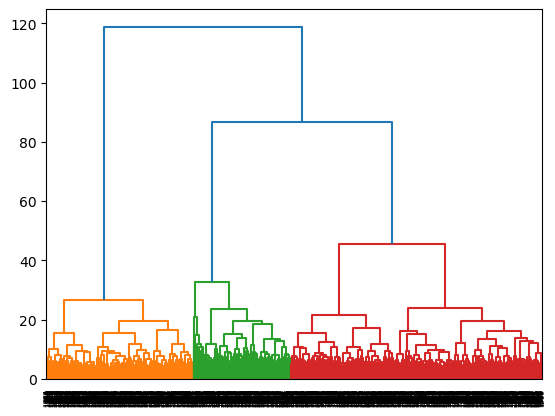

In [45]:
# Step 3: Hierarchical Clustering
# Perform hierarchical clustering on document embeddings
agg_clustering = AgglomerativeClustering(n_clusters=num_topics, linkage='ward')
topic_labels = agg_clustering.fit_predict(final_embeddings)

# Visualize the hierarchical clustering dendrogram (optional)
linkage_matrix = sch.linkage(final_embeddings.cpu().numpy(), method='ward')
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

# Assign topic labels to each document
df['topic'] = topic_labels



In [46]:
# Step 4: Topic Labeling
# You can manually inspect the documents within each topic cluster and assign labels based on content

# Print documents in each topic cluster
for topic_id in range(num_topics):
    print(f"Topic {topic_id}:")
    print(df[df['topic'] == topic_id]['text'].head(5))  # Display the first 5 documents in each topic

# Save the labeled dataset to a new CSV file
df.to_csv('labeled_dataset.csv', index=False)


Topic 0:
29    herzlich willkommen name weiterhelfen daten du...
31    herzlich kommen service weiß wolltest tun kund...
33    willkommen darf weiterhelfen leider extrem vie...
34    hallo wunderschönen guten tag herzlich willkom...
35    herzlich willkommen service name toklo behilfl...
Name: text, dtype: object
Topic 1:
0    brot urlaub name weiterhelfen ja leider verkeh...
2    guten tag herzlich willkommen sprechen leid ja...
3    herzlich willkommen service sprechen dominik t...
4    hallo schönen guten tag name firma ja vorliege...
5    herzlich willkommen motor ritter name helfen w...
Name: text, dtype: object
Topic 2:
12    guten tag sprechen sagen helfen ja geht angege...
13    guten tag name schon darf tun o. nachschauen n...
17    herzlich willkommen name systeme darf tun gar ...
19    herzlich willkommen name tun o. bräuchte persö...
20    herzlich willkommen salek darf tun ja ja warte...
Name: text, dtype: object
Topic 3:
1     schönen guten tag lauditag stehst ja name hel

In [47]:
data = pd.read_csv('labeled_dataset.csv')
data

,Unnamed: 0,file_name,text,Sales,filtered_text,topic
0,0,SOM_118_00055_FA163EF3DB12-1b43-e3615700-3dca9...,brot urlaub name weiterhelfen ja leider verkeh...,0,NaN,1
1,1,SOM_TPF_00101_FA163E22F5B7-1af3-de819700-4197c...,schönen guten tag lauditag stehst ja name helf...,0,lauditag stehst,3
2,2,SOM_141_00085_FA163E622DEB-1b45-68d0e700-3c9a0...,guten tag herzlich willkommen sprechen leid ja...,0,eta kumpel,1
3,3,SOM_LUB_00112_FA163E22F5B7-1af3-dc815700-45c46...,herzlich willkommen service sprechen dominik t...,0,bert bislang,1
4,4,SOM_AMV_00100_FA163E153AE3-1bb7-3f731700-3fe36...,hallo schönen guten tag name firma ja vorliege...,0,NaN,1
...,...,...,...,...,...,...
1993,395,SOM_LUB_00246_FA163EF3DB12-1b43-e3615700-3be4f...,herzlich willkommen service sprechen tun karte...,0,pending eingeschränkt eingeschränkt vorteilen,2
1994,396,SOM_VYD_00630_FA163ED88855-1bef-b9321700-412dc...,herzlich willkommen name weiterhelfen kurz per...,0,bahnhofstraße bahnhof bahnhofstraße ttt inhous...,2
1995,397,SOM_LUB_00379_FA163E622DEB-1b45-6850d700-3e961...,herzlich willkommen sprechen tarifberater ring...,0,rücksetzung aufgehängt rücksetzung frühen gene...,2
1996,398,SOM_TPF_00515_FA163E56E95C-1b1d-4929d700-3aab3...,herzlich willkommen blau buckel name darf tun ...,1,mso,2


In [49]:
data['topic'].value_counts()

topic
2    596
0    593
3    416
1    353
4     40
Name: count, dtype: int64

In [5]:
# Download the NLTK stop words list and wordnet for lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Snowball stemmer and WordNet lemmatizer
stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the preprocessing function to the DataFrame
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Print the cleaned DataFrame
print(df['cleaned_text'])


[nltk_data] Downloading package stopwords to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       brot urlaub nam weiterhelf leid verkehrt leit ...
1       schon gut tag lauditag steh nam helf geht rufn...
2       gut tag herzlich willkomm sprech leid helf bev...
3       herzlich willkomm servic sprech domin tun bitt...
4       hallo schon gut tag nam firma vorlieg wann wan...
                              ...                        
1993    herzlich willkomm servic sprech tun kart bitt ...
1994    herzlich willkomm nam weiterhelf kurz person k...
1995    herzlich willkomm sprech tarifberat ring plan ...
1996    herzlich willkomm blau buckel nam darf tun bit...
1997    herzlich willkomm servic sprech darf tun frau ...
Name: cleaned_text, Length: 1998, dtype: object


In [24]:
# Words to remove
words_to_remove = ['bitt', 'mal', 'schon', 'genau', 'dank', 'gut', 'tag', 'numm', 'person', 'kurz', 
                   'einfach', 'neu', 'schau', 'moment', 'sag', 'muss', 'geht', 'fall', 'ganz', 'war', 'gern', 'frag', 'gleich',
                  'guck', 'imm', 'halt', 'wurd', 'seh', 'natur', 'quasi', 'gerad', 'bekomm', 'rout', 'gesagt', 'nein', 'tun', 'syst',
                  'mehr', 'mocht', 'box', 'geh', 'zugangsdat', 'passwort', 'kennwort', 'steht', 'wlan', 'seit', 'klein', 'internet', 'bekomm', 'rufnumm', 
                   'kundenkennzahl', 'leid', 'tun', 'nam', 'per', 'willkomm', 'herzlich', 'gemacht', 'bleib', 'herr', 'kolleg',
                   'schick', 'frau', 'geb', 'richtig', 'vielleicht', 'viel',  'preis', 'kart', 'zahl', 'brot' urlaub ]

# Function to remove specified words from text
def remove_specific_words(text):
    # Tokenize the text
    tokens = text.split()
    
    # Filter out words to remove
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    
    # Join the remaining tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

# Apply the function to the 'cleaned_text' column
df['cleaned_text'] = df['cleaned_text'].apply(remove_specific_words)

# Print the cleaned DataFrame
print(df['cleaned_text'])


0       brot urlaub weiterhelf verkehrt leit direkt au...
1       lauditag steh helf end registri hinterleg weit...
2       sprech helf bevor erklar darf find erst nenn s...
3       servic sprech domin hatt sicherheitskennzahl s...
4       hallo firma vorlieg wann wann bestellt komisch...
                              ...                        
1993    servic sprech anruf nee entschuld angegeb end ...
1994    weiterhelf kennzahl nenn wann termin ungefahr ...
1995    sprech tarifberat ring plan momentch klar aktu...
1996    blau buckel darf telefonnumm wiederhol vielmal...
1997    servic sprech darf verstand einzelverbindungsn...
Name: cleaned_text, Length: 1998, dtype: object


In [18]:
df

,Unnamed: 0,file_name,text,Sales,filtered_text,cleaned_text
0,0,SOM_118_00055_FA163EF3DB12-1b43-e3615700-3dca9...,brot urlaub name weiterhelfen ja leider verkeh...,0,NaN,brot urlaub nam weiterhelf leid verkehrt leit ...
1,1,SOM_TPF_00101_FA163E22F5B7-1af3-de819700-4197c...,schönen guten tag lauditag stehst ja name helf...,0,lauditag stehst,lauditag steh nam helf rufnumm end kart regist...
2,2,SOM_141_00085_FA163E622DEB-1b45-68d0e700-3c9a0...,guten tag herzlich willkommen sprechen leid ja...,0,eta kumpel,herzlich willkomm sprech leid helf bevor erkla...
3,3,SOM_LUB_00112_FA163E22F5B7-1af3-dc815700-45c46...,herzlich willkommen service sprechen dominik t...,0,bert bislang,herzlich willkomm servic sprech domin tun hatt...
4,4,SOM_AMV_00100_FA163E153AE3-1bb7-3f731700-3fe36...,hallo schönen guten tag name firma ja vorliege...,0,NaN,hallo nam firma vorlieg wann wann bestellt kom...
...,...,...,...,...,...,...
1993,395,SOM_LUB_00246_FA163EF3DB12-1b43-e3615700-3be4f...,herzlich willkommen service sprechen tun karte...,0,pending eingeschränkt eingeschränkt vorteilen,herzlich willkomm servic sprech tun kart anruf...
1994,396,SOM_VYD_00630_FA163ED88855-1bef-b9321700-412dc...,herzlich willkommen name weiterhelfen kurz per...,0,bahnhofstraße bahnhof bahnhofstraße ttt inhous...,herzlich willkomm nam weiterhelf kennzahl nenn...
1995,397,SOM_LUB_00379_FA163E622DEB-1b45-6850d700-3e961...,herzlich willkommen sprechen tarifberater ring...,0,rücksetzung aufgehängt rücksetzung frühen gene...,herzlich willkomm sprech tarifberat ring plan ...
1996,398,SOM_TPF_00515_FA163E56E95C-1b1d-4929d700-3aab3...,herzlich willkommen blau buckel name darf tun ...,1,mso,herzlich willkomm blau buckel nam darf tun tel...


In [25]:
# Step 1: Topic Modeling (LDA)
# Convert text data to a document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['cleaned_text'])

In [26]:
# Apply LDA for topic modeling
num_topics = 5  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
def get_top_words(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_word_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [words[i] for i in top_word_idx]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

topics = get_top_words(lda, vectorizer)
print("Top words for each topic:")
for topic, top_words in topics.items():
    print(f"{topic}: {', '.join(top_words)}")

Top words for each topic:
Topic 1: vertrag, bestell, wunsch, heut, brauch, technik, uhr, anbiet, morg, erst
Topic 2: vertrag, monat, tarif, auftrag, angebot, bestat, buch, punkt, weit, widerrufsbelehr
Topic 3: probl, storung, sms, bewert, technik, darf, adress, anruf, wunsch, funktioniert
Topic 4: monat, vertrag, tarif, angebot, rabatt, rechnung, bezahl, moglich, gibt, erst
Topic 5: vertrag, versteh, kundig, find, brauch, gar, erst, dat, klar, rechnung
